<a href="https://colab.research.google.com/github/dillonph34/Team_32/blob/main/NUS_DSESC_DATABUSTERS_32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1) Libraries Installation
##### The cell below is to help you keep track the libraries used and install them quickly.
##### Ensure the correct library names are used, and follow the syntax: **%pip install PACKAGE_NAME**.

In [1]:
import rpy2.robjects as ro
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from rpy2.robjects import pandas2ri
!pip install rpy2
%load_ext rpy2.ipython
ro.r('install.packages(c("ggplot2", "readr", "dplyr", "tidyr", "scales", "forecast", "lubridate", "tseries", "glmnet", "tidyverse"))')
ro.r('library(ggplot2)')
ro.r('library(readr)')
ro.r('library(dplyr)')
ro.r('library(tidyr)')
ro.r('library(scales)')
ro.r('library(forecast)')
ro.r('library(lubridate)')
ro.r('library(tseries)')
ro.r('library(glmnet)')
ro.r('library(tidyverse)')


(as ‘lib’ is unspecified)




























































































































	‘/tmp/RtmpZfPJFx/downloaded_packages’

Attaching package: ‘dplyr’



    filter, lag



    intersect, setdiff, setequal, union


Attaching package: ‘scales’



    col_factor


  method            from
  as.zoo.data.frame zoo 

Attaching package: ‘lubridate’



    date, intersect, setdiff, union


    ‘tseries’ version: 0.10-58

    ‘tseries’ is a package for time series analysis and computational
    finance.

    See ‘library(help="tseries")’ for details.



Attaching package: ‘Matrix’



    expand, pack, unpack





── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats 1.0.0     ✔ stringr 1.5.1
✔ purrr   1.0.4     ✔ tibble  3.2.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ scales::col_factor() masks readr::col_factor()
✖ purrr::discard()     masks scales::discard()
✖ Matrix::expand()     masks tidyr::expand()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::lag()         masks stats::lag()
✖ Matrix::pack()       masks tidyr::pack()
✖ Matrix::unpack()     masks tidyr::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


'forcats','stringr','purrr',...,'datasets','methods','base'


## 2) Main Section for Code
### **ALL code for machine learning and dataset analysis** should be entered below.
##### Ensure that your code is clear and readable.
##### Remember to include comments and markdown notes as necessary to explain and highlight important segments of your code.

In [2]:
%%R
# load dataset
master_data = read.csv("https://raw.githubusercontent.com/starryfieldz/Databusters/refs/heads/main/Quarterly%20Data.csv")

# remove metadata rows
data <- master_data[-c(1,2),]

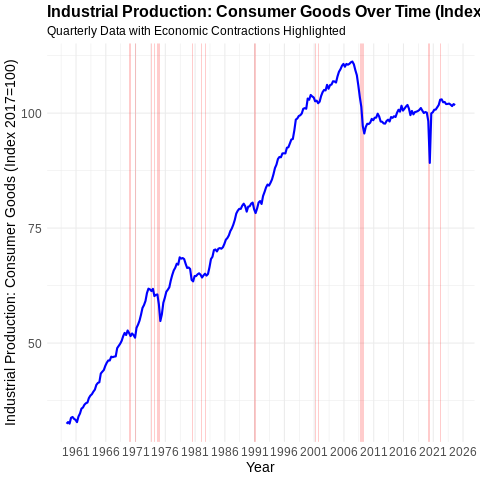

In [3]:
%%R
# Template code for plotting predictor against time (With economic contractions highlighted)
# The following code is for IPCONGD


# convert 'sasdate' column to proper Date format
data$sasdate <- as.Date(data$sasdate, format="%m/%d/%Y")

# ensure all columns are numeric (except date)
data <- data %>% mutate(across(where(is.character), as.numeric))

# compute GDP growth as the response variable
data <- data %>% mutate(GDP_growth = (GDPC1 - lag(GDPC1)) / lag(GDPC1) * 100)

# remove first row (which contains NA from lag function)
data <- data[-1, ]

# define binary contraction indicator (1 if GDP growth is negative, 0 otherwise)
data <- data %>% mutate(Econ_Contraction = ifelse(GDP_growth < 0, 1, 0))

# identify start and end of contraction periods
data <- data %>%
  mutate(
    contraction_start = ifelse(Econ_Contraction == 1 & lag(Econ_Contraction, default = 0) == 0, sasdate, NA),
    contraction_end = ifelse(Econ_Contraction == 1 & lead(Econ_Contraction, default = 0) == 0, sasdate, NA)
  )

# ensure contraction_start and contraction_end are Dates before filling
data <- data %>%
  mutate(
    contraction_start = as.Date(contraction_start, origin = "1970-01-01"),
    contraction_end = as.Date(contraction_end, origin = "1970-01-01")
  )

# extract start and end dates for contraction periods
contraction_periods <- data %>%
  filter(!is.na(contraction_start) | !is.na(contraction_end)) %>%
  select(contraction_start, contraction_end) %>%
  tidyr::fill(contraction_start, .direction = "down") %>%
  tidyr::fill(contraction_end, .direction = "up") %>%
  filter(!is.na(contraction_start) & !is.na(contraction_end)) %>%
  distinct()

# ensure single-quarter contractions are visible
contraction_periods <- contraction_periods %>%
  mutate(
    contraction_end = ifelse(contraction_start == contraction_end, contraction_end + 30, contraction_end)
  )

# ensure contraction periods are correctly formatted as Dates AFTER fill()
contraction_periods <- contraction_periods %>%
  mutate(
    contraction_start = as.Date(contraction_start, origin = "1970-01-01"),
    contraction_end = as.Date(contraction_end, origin = "1970-01-01")
  )

# plot IPCONGD against time with economic contractions highlighted
ggplot(data, aes(x = sasdate, y = IPCONGD)) +
  # Highlight periods of economic contraction
  geom_rect(data = contraction_periods,
            aes(xmin = contraction_start, xmax = contraction_end, ymin = -Inf, ymax = Inf),
            inherit.aes = FALSE, fill = "red", alpha = 0.2) +

  # Plot IPCONGD as a line
  geom_line(color = "blue", size = 1) +

  # Fix the X-axis to show proper years
  scale_x_date(date_breaks = "5 years", date_labels = "%Y") +

  # Format Y-axis with comma separators
  scale_y_continuous(labels = scales::comma) +

  # Add title, labels, and theme
  labs(
    title = "Industrial Production: Consumer Goods Over Time (Index 2017=100)",
    subtitle = "Quarterly Data with Economic Contractions Highlighted",
    x = "Year",
    y = "Industrial Production: Consumer Goods (Index 2017=100)",
    color = "Legend"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    plot.subtitle = element_text(size = 12),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12)
  )




	Augmented Dickey-Fuller Test

data:  gdp_ts
Dickey-Fuller = -6.5922, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary

  Quarter Predicted_GDP_Growth
1 Q1 2025            0.2418548
2 Q2 2025            0.3070016
3 Q3 2025            0.4097709
4 Q4 2025            0.3842151
  Quarter Predicted_GDP_Growth   Lower_80  Upper_80   Lower_95 Upper_95
1 Q1 2025            0.2418548 -0.2843332 0.7680429 -0.5628804 1.046590
2 Q2 2025            0.3070016 -0.2300155 0.8440186 -0.5142952 1.128298
3 Q3 2025            0.4097709 -0.1276918 0.9472336 -0.4122073 1.231749
4 Q4 2025            0.3842151 -0.1532661 0.9216963 -0.4377914 1.206222


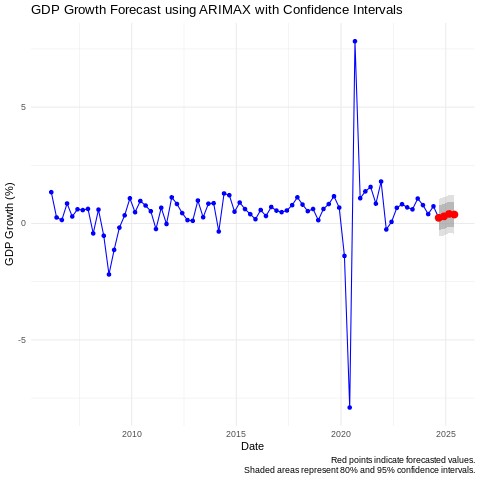

In [4]:
%%R
# Forecasting the next 4 quarters with ARIMAX, as well as testing GDP Growth for stationarity
data2 <- master_data[-c(1,2), ]

# convert 'sasdate' column to Date format
data2$sasdate <- as.Date(data2$sasdate, format="%m/%d/%Y")

# ensure all columns are numeric (except 'sasdate')
data2 <- data2 %>% mutate(across(where(is.character), as.numeric))

# compute GDP growth as the response variable
data2 <- data2 %>% mutate(GDP_growth = (GDPC1 - lag(GDPC1)) / lag(GDPC1) * 100)

# remove first row (which contains NA from lag function)
data2 <- data2[-1, ]
# convert GDP Growth to Time Series
gdp_ts <- ts(data2$GDP_growth, start = c(year(min(data2$sasdate)), quarter(min(data2$sasdate))), frequency = 4)


# # perform Augmented Dickey-Fuller (ADF) Test
adf_result <- adf.test(gdp_ts)

# # print ADF Test Result
print(adf_result)

# define the selected predictors
predictors <- c("A014RE1Q156NBEA", "IPDCONGD", "IPB51110SQ", "UEMPLT5",
                "UEMP15T26", "HOUSTMW", "BAA10YM", "VIXCLSx", "AAAFFM",
                "TNWMVBSNNCBx", "CLAIMSx", "PERMITMW", "OILPRICEx", "PRFIx")

# keep only the available predictors
available_predictors <- predictors[predictors %in% colnames(data2)]

# compute PRFIx_percent_change manually if PRFIx exists
if ("PRFIx" %in% available_predictors) {
  data2 <- data2 %>% mutate(PRFIx_percent_change = (PRFIx - lag(PRFIx)) / lag(PRFIx) * 100)
  available_predictors <- c(setdiff(available_predictors, "PRFIx"), "PRFIx_percent_change")
}

# remove NA values after computing percent change
data2 <- na.omit(data2)

# prepare the dataset
X <- data2 %>% select(all_of(available_predictors))
y <- data2$GDP_growth

# convert data to time series format
gdp_ts <- ts(y, start = c(year(min(data2$sasdate)), quarter(min(data2$sasdate))), frequency = 4)
X_ts <- ts(X, start = c(year(min(data2$sasdate)), quarter(min(data2$sasdate))), frequency = 4)

# fit an ARIMAX model (ARIMA with exogenous variables)
arimax_model <- auto.arima(gdp_ts, xreg = X_ts, seasonal = TRUE, stepwise = FALSE, approximation = FALSE)

# print model summary
summary(arimax_model)

# forecast GDP growth for Q1 2025, Q2 2025, Q3 2025, Q4 2025
future_quarters <- 4  # Forecasting up to 4 quarters ahead

# generate future dates
future_dates <- seq(max(data2$sasdate) + months(3), by = "quarter", length.out = future_quarters)

# correctly structure future_X to match required rows
future_X <- data.frame(matrix(ncol = length(available_predictors), nrow = future_quarters))
colnames(future_X) <- available_predictors

# predict future values using linear regression
for (col in available_predictors) {
  model <- lm(data2[[col]] ~ as.numeric(data2$sasdate))  # Fit a linear model
  future_X[[col]] <- predict(model, newdata = data.frame(sasdate = as.numeric(future_dates)))[1:future_quarters]
}

# forecasting with the ARIMAX model
forecast_values <- forecast(arimax_model, xreg = as.matrix(future_X), h = future_quarters)

# extract forecasted values
forecast_gdp_growth <- data.frame(
  Quarter = c("Q1 2025", "Q2 2025", "Q3 2025", "Q4 2025"),
  Predicted_GDP_Growth = forecast_values$mean
)

# print forecasted GDP growth
print(forecast_gdp_growth)

# create forecast plot
forecast_df <- data.frame(
  Date = future_dates,
  Predicted_GDP_Growth = forecast_values$mean
)

# merge actual data and forecast
actual_df <- data.frame(Date = data2$sasdate, GDP_growth = y)
plot_data <- bind_rows(actual_df %>% rename(Predicted_GDP_Growth = GDP_growth), forecast_df)

# extract forecasted values and confidence intervals
forecast_gdp_growth <- data.frame(
  Date = future_dates,
  Predicted_GDP_Growth = forecast_values$mean,
  Lower_80 = forecast_values$lower[,1],  # 80% lower bound
  Upper_80 = forecast_values$upper[,1],  # 80% upper bound
  Lower_95 = forecast_values$lower[,2],  # 95% lower bound
  Upper_95 = forecast_values$upper[,2]   # 95% upper bound
)

# merge actual data and forecast
actual_df <- data.frame(Date = data2$sasdate, GDP_growth = y)
plot_data <- bind_rows(actual_df %>% rename(Predicted_GDP_Growth = GDP_growth), forecast_gdp_growth)

# plot historical and forecasted GDP growth with confidence intervals
print(ggplot(plot_data, aes(x = Date, y = Predicted_GDP_Growth)) +
  geom_line(color = "blue") +
  geom_point(color = "blue") +
  # Confidence interval 95% (wider range)
  geom_ribbon(data = forecast_gdp_growth, aes(ymin = Lower_95, ymax = Upper_95), fill = "gray70", alpha = 0.4) +
  # Confidence interval 80% (narrower range)
  geom_ribbon(data = forecast_gdp_growth, aes(ymin = Lower_80, ymax = Upper_80), fill = "gray50", alpha = 0.4) +
  # Forecasted values
  geom_point(data = forecast_gdp_growth, aes(x = Date, y = Predicted_GDP_Growth), color = "red", size = 3) +
  geom_line(data = forecast_gdp_growth, aes(x = Date, y = Predicted_GDP_Growth), color = "red", linetype = "dashed") +
  labs(title = "GDP Growth Forecast using ARIMAX with Confidence Intervals",
       x = "Date", y = "GDP Growth (%)",
       caption = "Red points indicate forecasted values.\nShaded areas represent 80% and 95% confidence intervals.") +
  theme_minimal())

# print forecasted GDP growth with confidence intervals
forecast_output <- data.frame(
  Quarter = c("Q1 2025", "Q2 2025", "Q3 2025", "Q4 2025"),
  Predicted_GDP_Growth = forecast_values$mean,
  Lower_80 = forecast_values$lower[,1],  # 80% confidence lower bound
  Upper_80 = forecast_values$upper[,1],  # 80% confidence upper bound
  Lower_95 = forecast_values$lower[,2],  # 95% confidence lower bound
  Upper_95 = forecast_values$upper[,2]   # 95% confidence upper bound
)

# print the results
print(forecast_output)

In [5]:
#XGB Classifier
pandas2ri.activate()

# Get the R dataframe into a Python variable
master_data_py = ro.r['master_data']

quarterly_data = master_data_py.iloc[2:].reset_index(drop=True)


quarterly_data['GDP_lag1'] = quarterly_data['GDPC1'].shift(1)
quarterly_data['GDP_lag2'] = quarterly_data['GDPC1'].shift(2)

quarterly_data["GDP_percent_change"] = quarterly_data["GDPC1"]

quarterly_data["GDP_percent_change"] = quarterly_data["GDPC1"].pct_change() * 100

# Replace the first NaN value with 0
quarterly_data["GDP_percent_change"] = quarterly_data["GDP_percent_change"].fillna(0)

quarterly_data["IPBUSEQ_percent_change"] = quarterly_data["IPBUSEQ"].pct_change() * 100
quarterly_data["IPCONGD_percent_change"] = quarterly_data["IPCONGD"].pct_change() * 100
quarterly_data["PRFIx_percent_change"] = quarterly_data["PRFIx"].pct_change() * 100

# Replace the first NaN value with 0
quarterly_data["IPBUSEQ_percent_change"] = quarterly_data["IPBUSEQ_percent_change"].fillna(0)
quarterly_data["IPCONGD_percent_change"] = quarterly_data["IPCONGD_percent_change"].fillna(0)
quarterly_data["PRFIx_percent_change"] = quarterly_data["PRFIx_percent_change"].fillna(0)

quarterly_data['IPBUSEQ_percent_change_lag2'] = quarterly_data['IPBUSEQ_percent_change'].shift(2)
quarterly_data['IPBUSEQ_percent_change_lag1'] = quarterly_data['IPBUSEQ_percent_change'].shift(1)

quarterly_data['IPCONGD_percent_change_lag1'] = quarterly_data['IPCONGD_percent_change'].shift(1)
quarterly_data['IPCONGD_percent_change_lag2'] = quarterly_data['IPCONGD_percent_change'].shift(2)

quarterly_data['PRFIx_percent_change_lag1'] = quarterly_data['PRFIx_percent_change'].shift(1)
quarterly_data['PRFIx_percent_change_lag2'] = quarterly_data['PRFIx_percent_change'].shift(2)

In [6]:
quarterly_data['PRFIx_change'] = quarterly_data['PRFIx'].diff()  # Compute change
quarterly_data['PRFIx_drop_streak'] = 0  # Initialize streak counter

for i in range(1, len(quarterly_data)):
    if quarterly_data.loc[i, 'PRFIx_change'] < 0:  # If drop
        quarterly_data.loc[i, 'PRFIx_drop_streak'] = quarterly_data.loc[i - 1, 'PRFIx_drop_streak'] + 1
    else:
        quarterly_data.loc[i, 'PRFIx_drop_streak'] = 0

quarterly_data.drop(columns=['PRFIx_change'], inplace=True)

print(quarterly_data[['PRFIx', 'PRFIx_drop_streak']].head(20))

       PRFIx  PRFIx_drop_streak
0   282.9707                  0
1   292.8479                  0
2   287.3778                  1
3   279.2502                  2
4   287.8417                  0
5   264.2765                  1
6   256.3818                  2
7   256.0874                  3
8   257.1344                  0
9   258.1340                  0
10  272.2332                  0
11  281.4676                  0
12  286.3771                  0
13  295.2804                  0
14  295.0222                  1
15  294.5802                  2
16  305.0030                  0
17  326.8811                  0
18  333.1392                  0
19  343.6665                  0


In [7]:
quarterly_data['GS10TB3Mx_change'] = quarterly_data['GS10TB3Mx'].diff()  # Compute change
quarterly_data['GS10TB3Mx_drop_streak'] = 0  # Initialize streak counter

for i in range(1, len(quarterly_data)):
    if quarterly_data.loc[i, 'GS10TB3Mx_change'] < 0:  # If drop
        quarterly_data.loc[i, 'GS10TB3Mx_drop_streak'] = quarterly_data.loc[i - 1, 'GS10TB3Mx_drop_streak'] + 1
    else:
        quarterly_data.loc[i, 'GS10TB3Mx_drop_streak'] = 0

quarterly_data.drop(columns=['GS10TB3Mx_change'], inplace=True)

print(quarterly_data[['GS10TB3Mx', 'GS10TB3Mx_drop_streak']].head(20))

    GS10TB3Mx  GS10TB3Mx_drop_streak
0        1.22                      0
1        1.26                      0
2        0.96                      1
3        0.35                      2
4        0.61                      0
5        1.27                      0
6        1.47                      0
7        1.58                      0
8        1.44                      1
9        1.49                      0
10       1.68                      0
11       1.51                      1
12       1.29                      2
13       1.16                      3
14       1.15                      4
15       1.09                      5
16       0.99                      6
17       1.02                      0
18       0.74                      1
19       0.62                      2


In [8]:
quarterly_data['GS10TB3Mx_drop_streak_lag4'] = quarterly_data['GS10TB3Mx_drop_streak'].shift(4)
quarterly_data['GS10TB3Mx_drop_streak_lag3'] = quarterly_data['GS10TB3Mx_drop_streak'].shift(3)
quarterly_data['GS10TB3Mx_drop_streak_lag2'] = quarterly_data['GS10TB3Mx_drop_streak'].shift(2)
quarterly_data['GS10TB3Mx_drop_streak_lag1'] = quarterly_data['GS10TB3Mx_drop_streak'].shift(1)

In [9]:
quarterly_data['GS10TB3Mx_drop_streak_lag4']

,GS10TB3Mx_drop_streak_lag4
0,NaN
1,NaN
2,NaN
3,NaN
4,0.0
...,...
258,1.0
259,2.0
260,3.0
261,4.0


In [10]:
quarterly_model_df = quarterly_data.iloc[-74:]
quarterly_model_df = quarterly_model_df.drop(columns=["GDPC1", "sasdate"])

quarterly_model_df['contraction'] = (quarterly_model_df['GDP_percent_change'] < 0).astype(int)

print(quarterly_model_df[['GDP_percent_change', 'contraction']].head(20))

     GDP_percent_change  contraction
189            0.258753            0
190            0.149956            0
191            0.859450            0
192            0.300836            0
193            0.611762            0
194            0.576026            0
195            0.628237            0
196           -0.426764            1
197            0.595428            0
198           -0.525258            1
199           -2.189027            1
200           -1.134874            1
201           -0.178651            1
202            0.351192            0
203            1.080914            0
204            0.484501            0
205            0.967586            0
206            0.771085            0
207            0.525110            0
208           -0.237205            1


In [11]:
quarterly_model_df = quarterly_model_df.drop(columns=["GDP_percent_change"])
quarterly_model_df['contraction'] = quarterly_model_df.pop('contraction')

In [12]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(quarterly_model_df, test_size=0.2, shuffle=False)

In [13]:
scaler = MinMaxScaler()
train_features = train_data.iloc[:, :-1].values  # All columns except the target
scaler.fit(train_features)

# Transform both training and testing data
X_train= scaler.transform(train_features)
X_test = scaler.transform(test_data.iloc[:, :-1].values)
y_train = train_data.iloc[:, -1].values
y_test = test_data.iloc[:, -1].values

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:542: RuntimeWarning: invalid value encountered in multiply
  X *= self.scale_


In [14]:
y_test

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model = XGBClassifier()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)

<Axes: ylabel='Feature'>

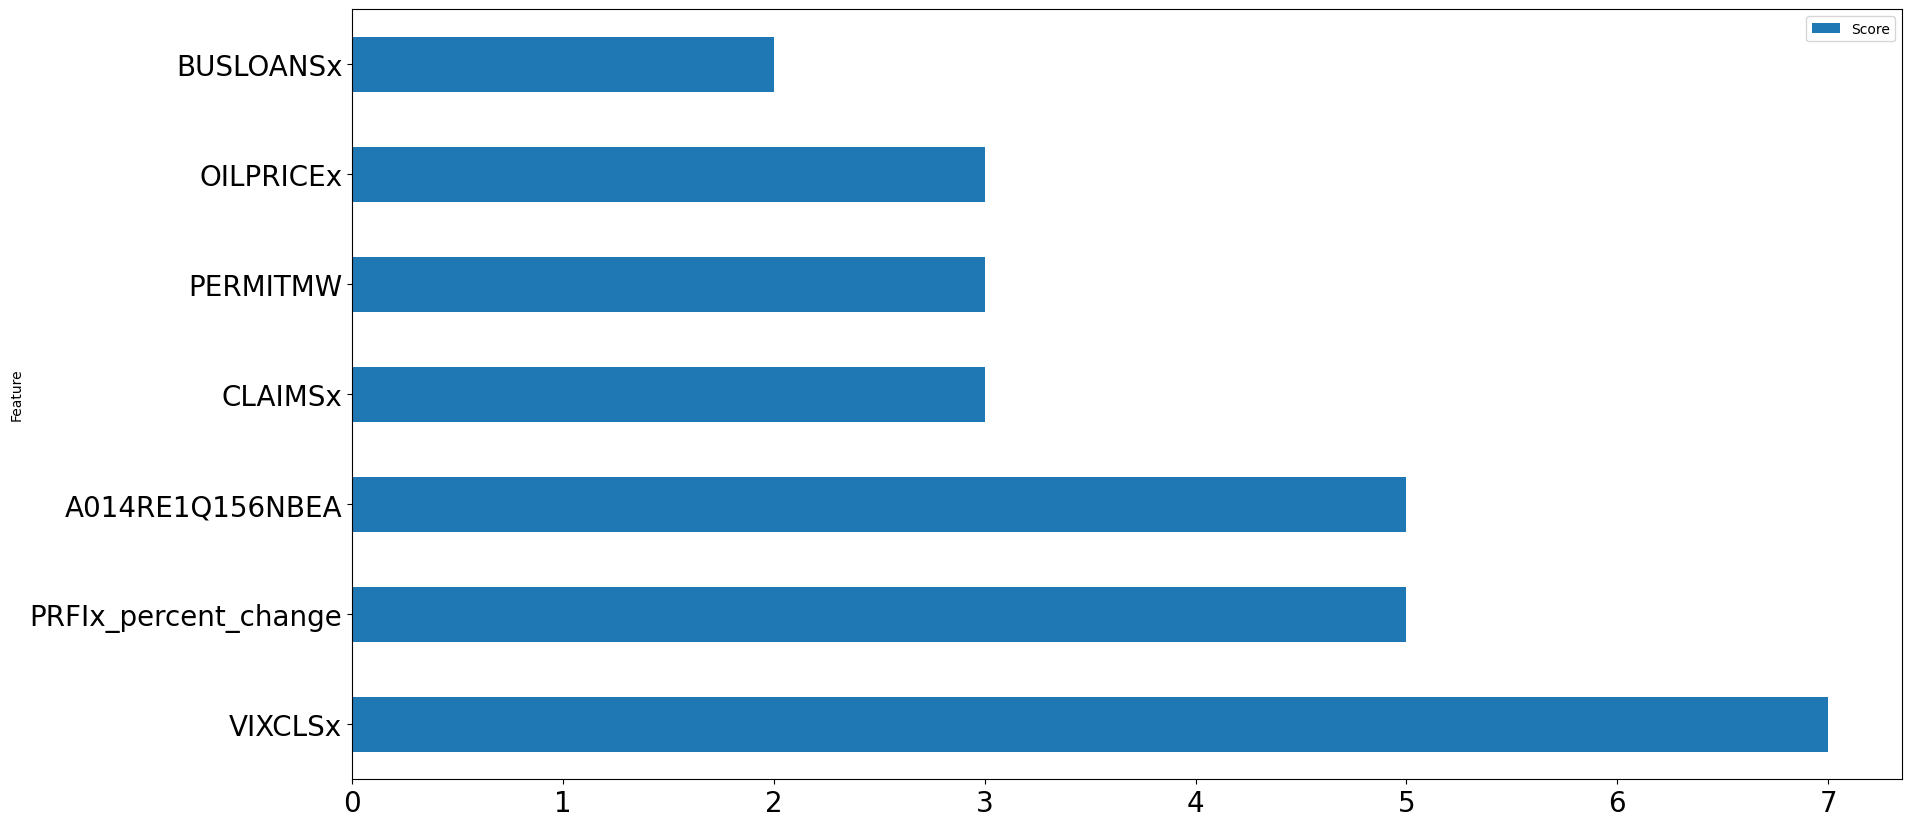

In [16]:
feature_important = model.get_booster().get_score(importance_type='weight')

# Get the feature names from your training data columns
feature_names = quarterly_model_df.columns[:-1]  # Exclude the target column

# Map 'f0', 'f1', etc., to actual feature names (handling missing keys safely)
feature_mapping = {f"f{i}": feature_names[i] for i in range(len(feature_names))}

# Only map keys that exist in feature_mapping
mapped_feature_important = {feature_mapping.get(key, key): value for key, value in feature_important.items()}

# Convert to DataFrame
feature_importance_df = pd.DataFrame(list(mapped_feature_important.items()), columns=["Feature", "Score"])
feature_importance_df = feature_importance_df.sort_values(by="Score", ascending=True)

# Plot feature importance
feature_importance_df.nlargest(7, columns="Score").plot(kind='barh', x="Feature", fontsize=20, y="Score", figsize=(20,10))

In [17]:
top_10_features = feature_importance_df.nlargest(10, columns="Score")["Feature"].tolist()
top_10_features

['VIXCLSx',
 'PRFIx_percent_change',
 'A014RE1Q156NBEA',
 'CLAIMSx',
 'PERMITMW',
 'OILPRICEx',
 'BUSLOANSx',
 'IPBUSEQ_percent_change',
 'GDP_lag1',
 'WPSID62']

In [18]:
quarterly_data = quarterly_data.iloc[2:].reset_index(drop=True)

quarterly_data['GDP_lag1'] = quarterly_data['GDPC1'].shift(1)
quarterly_data['GDP_lag2'] = quarterly_data['GDPC1'].shift(2)

quarterly_data["GDP_percent_change"] = quarterly_data["GDPC1"].pct_change() * 100

# Replace the first NaN value with 0
quarterly_data["GDP_percent_change"] = quarterly_data["GDP_percent_change"].fillna(0)

quarterly_data["IPBUSEQ_percent_change"] = quarterly_data["IPBUSEQ"].pct_change() * 100
quarterly_data["IPCONGD_percent_change"] = quarterly_data["IPCONGD"].pct_change() * 100
quarterly_data["PRFIx_percent_change"] = quarterly_data["PRFIx"].pct_change() * 100

# Replace the first NaN value with 0
quarterly_data["IPBUSEQ_percent_change"] = quarterly_data["IPBUSEQ_percent_change"].fillna(0)
quarterly_data["IPCONGD_percent_change"] = quarterly_data["IPCONGD_percent_change"].fillna(0)
quarterly_data["PRFIx_percent_change"] = quarterly_data["PRFIx_percent_change"].fillna(0)


quarterly_data['IPBUSEQ_percent_change_lag2'] = quarterly_data['IPBUSEQ_percent_change'].shift(2)
quarterly_data['IPBUSEQ_percent_change_lag1'] = quarterly_data['IPBUSEQ_percent_change'].shift(1)

quarterly_data['IPCONGD_percent_change_lag1'] = quarterly_data['IPCONGD_percent_change'].shift(1)
quarterly_data['IPCONGD_percent_change_lag2'] = quarterly_data['IPCONGD_percent_change'].shift(2)

quarterly_data['PRFIx_percent_change_lag1'] = quarterly_data['PRFIx_percent_change'].shift(1)
quarterly_data['PRFIx_percent_change_lag2'] = quarterly_data['PRFIx_percent_change'].shift(2)

In [19]:
quarterly_data['PRFIx_change'] = quarterly_data['PRFIx'].diff()  # Compute change
quarterly_data['PRFIx_drop_streak'] = 0  # Initialize streak counter

for i in range(1, len(quarterly_data)):
    if quarterly_data.loc[i, 'PRFIx_change'] < 0:  # If drop
        quarterly_data.loc[i, 'PRFIx_drop_streak'] = quarterly_data.loc[i - 1, 'PRFIx_drop_streak'] + 1
    else:
        quarterly_data.loc[i, 'PRFIx_drop_streak'] = 0

quarterly_data.drop(columns=['PRFIx_change'], inplace=True)

print(quarterly_data[['PRFIx', 'PRFIx_drop_streak']].head(20))

       PRFIx  PRFIx_drop_streak
0   287.3778                  0
1   279.2502                  1
2   287.8417                  0
3   264.2765                  1
4   256.3818                  2
5   256.0874                  3
6   257.1344                  0
7   258.1340                  0
8   272.2332                  0
9   281.4676                  0
10  286.3771                  0
11  295.2804                  0
12  295.0222                  1
13  294.5802                  2
14  305.0030                  0
15  326.8811                  0
16  333.1392                  0
17  343.6665                  0
18  364.8510                  0
19  346.6904                  1


In [20]:
quarterly_data['GS10TB3Mx_change'] = quarterly_data['GS10TB3Mx'].diff()  # Compute change
quarterly_data['GS10TB3Mx_drop_streak'] = 0  # Initialize streak counter

for i in range(1, len(quarterly_data)):
    if quarterly_data.loc[i, 'GS10TB3Mx_change'] < 0:  # If drop
        quarterly_data.loc[i, 'GS10TB3Mx_drop_streak'] = quarterly_data.loc[i - 1, 'GS10TB3Mx_drop_streak'] + 1
    else:
        quarterly_data.loc[i, 'GS10TB3Mx_drop_streak'] = 0

quarterly_data.drop(columns=['GS10TB3Mx_change'], inplace=True)

print(quarterly_data[['GS10TB3Mx', 'GS10TB3Mx_drop_streak']].head(20))

    GS10TB3Mx  GS10TB3Mx_drop_streak
0        0.96                      0
1        0.35                      1
2        0.61                      0
3        1.27                      0
4        1.47                      0
5        1.58                      0
6        1.44                      1
7        1.49                      0
8        1.68                      0
9        1.51                      1
10       1.29                      2
11       1.16                      3
12       1.15                      4
13       1.09                      5
14       0.99                      6
15       1.02                      0
16       0.74                      1
17       0.62                      2
18       0.65                      0
19       0.72                      0


In [21]:
quarterly_data['GS10TB3Mx_drop_streak_lag4'] = quarterly_data['GS10TB3Mx_drop_streak'].shift(4)
quarterly_data['GS10TB3Mx_drop_streak_lag3'] = quarterly_data['GS10TB3Mx_drop_streak'].shift(3)
quarterly_data['GS10TB3Mx_drop_streak_lag2'] = quarterly_data['GS10TB3Mx_drop_streak'].shift(2)
quarterly_data['GS10TB3Mx_drop_streak_lag1'] = quarterly_data['GS10TB3Mx_drop_streak'].shift(1)

In [22]:
quarterly_data['GS10TB3Mx_drop_streak_lag4']

,GS10TB3Mx_drop_streak_lag4
0,NaN
1,NaN
2,NaN
3,NaN
4,0.0
...,...
256,1.0
257,2.0
258,3.0
259,4.0


In [23]:
quarterly_model_df = quarterly_data.iloc[-74:]
quarterly_model_df = quarterly_model_df.drop(columns=["GDPC1", "sasdate"])

In [24]:
quarterly_model_df["GDP_percent_change"] = quarterly_model_df.pop("GDP_percent_change")

In [25]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(quarterly_model_df, test_size=0.2, shuffle=False)

In [26]:
scaler = MinMaxScaler()
train_features = train_data.iloc[:, :-1].values  # All columns except the target
scaler.fit(train_features)

# Transform both training and testing data (to ensure consistent scaling)
X_train= scaler.transform(train_features)
X_test = scaler.transform(test_data.iloc[:, :-1].values)
y_train = train_data.iloc[:, -1].values
y_test = test_data.iloc[:, -1].values

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:542: RuntimeWarning: invalid value encountered in multiply
  X *= self.scale_


In [27]:
y_test

array([ 1.38018614,  1.57004487,  0.8528494 ,  1.80315891, -0.25745447,
        0.07017944,  0.6732082 ,  0.82782792,  0.69204379,  0.60697389,
        1.07152279,  0.7886727 ,  0.40480214,  0.73897962,  0.75951048])

In [28]:
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
model = XGBRegressor()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

<Axes: ylabel='Feature'>

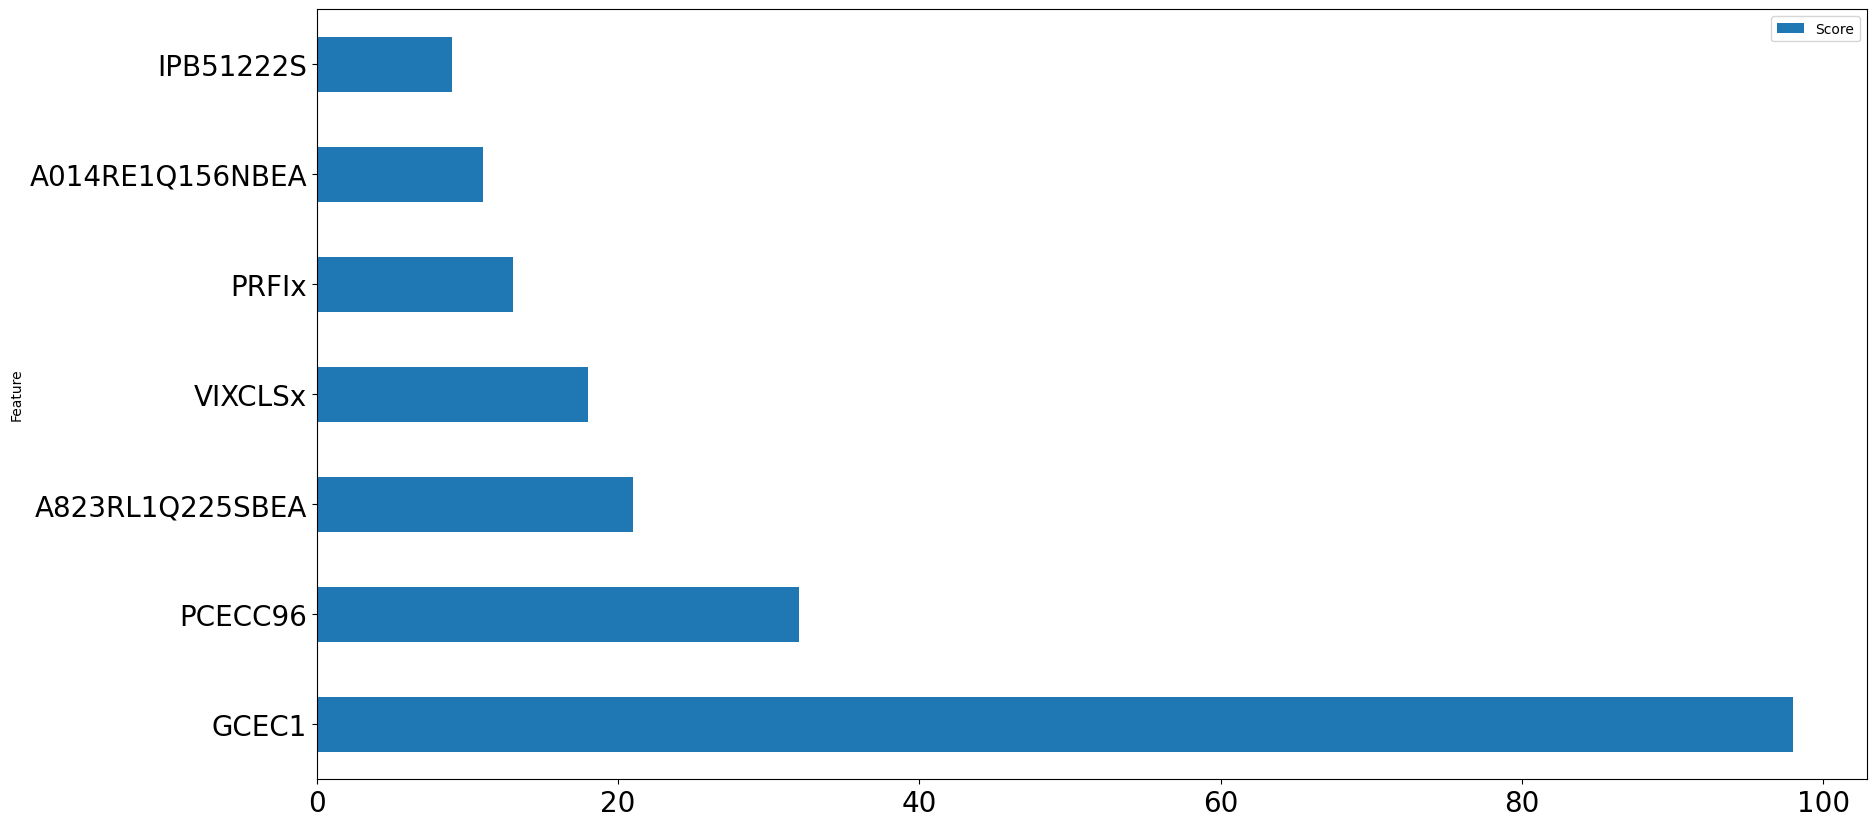

In [29]:
feature_important = model.get_booster().get_score(importance_type='weight')

# Get the feature names from your training data columns
feature_names = quarterly_model_df.columns[:-1]  # Exclude the target column

# Map 'f0', 'f1', etc., to actual feature names (handling missing keys safely)
feature_mapping = {f"f{i}": feature_names[i] for i in range(len(feature_names))}

# Only map keys that exist in feature_mapping
mapped_feature_important = {feature_mapping.get(key, key): value for key, value in feature_important.items()}

# Convert to DataFrame
feature_importance_df = pd.DataFrame(list(mapped_feature_important.items()), columns=["Feature", "Score"])
feature_importance_df = feature_importance_df.sort_values(by="Score", ascending=True)

# Plot feature importance
feature_importance_df.nlargest(7, columns="Score").plot(kind='barh', x="Feature", fontsize=20, y="Score", figsize=(20,10))

In [30]:
top_10_features_part2 = feature_importance_df.nlargest(10, columns="Score")["Feature"].tolist()
top_10_features_part2

['GCEC1',
 'PCECC96',
 'A823RL1Q225SBEA',
 'VIXCLSx',
 'PRFIx',
 'A014RE1Q156NBEA',
 'IPB51222S',
 'IPBUSEQ_percent_change',
 'MORTG10YRx',
 'CNCFx']

In [31]:
%%R
monthly_data = read.csv("https://raw.githubusercontent.com/starryfieldz/Databusters/refs/heads/main/Monthly%20Data.csv")


In [32]:
%%R
rm(list = ls())
library(tidyverse)
library(glmnet)


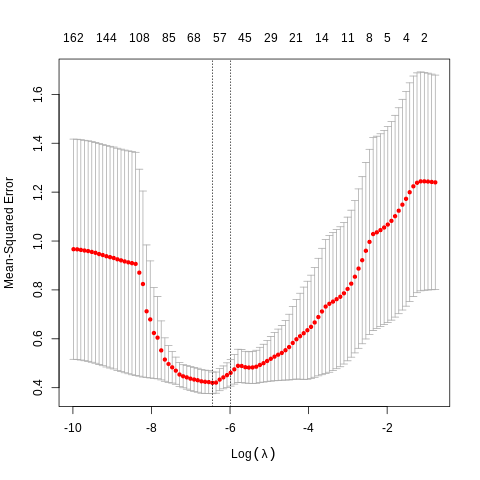

In [33]:
%%R
quarterly_data = read.csv("https://raw.githubusercontent.com/starryfieldz/Databusters/refs/heads/main/Quarterly%20Data.csv")
quarterly_data <- quarterly_data[-c(1, 2), ]

quarterly_data$GDP_percent_change <- c(NA, diff(quarterly_data$GDPC1) / head(quarterly_data$GDPC1, -1) * 100)

quarterly_data$GDP_percent_change[1] <- 0

quarterly_data_no_null <- quarterly_data %>% select(where(~ !any(is.na(.))))

quarterly_data_no_null <- quarterly_data_no_null %>%
  subset(select = -c(sasdate, GDPC1, GDPCTPI)) %>%
  na.omit()

quarterly_data_clean <- na.omit(quarterly_data)

quarterly_data_clean <- quarterly_data_clean %>%
  subset(select = -c(sasdate)) %>%
  na.omit()

quarterly_data_clean$GDP_percent_change


# nrow(Xmat)
# nrow(quarterly_data_clean)
# nrow(Xmat_col)
# nrow(quarterly_data_no_null)


Xmat <- model.matrix(GDP_percent_change ~ . , data = quarterly_data_no_null)[ , -1]
yvec <- quarterly_data_no_null$GDP_percent_change

set.seed(321)
TrainInd <- sample(1:nrow(quarterly_data_no_null), floor(.8*nrow(quarterly_data_no_null)))
set.seed(NULL)

Train <- quarterly_data_no_null[TrainInd, ]
Validation <- quarterly_data_no_null[-TrainInd, ]
XmatTrain <- Xmat[TrainInd, ]
XmatValidation <- Xmat[-TrainInd, ]

yvecTrain <- yvec[TrainInd]
yvecValidation <- yvec[-TrainInd]

set.seed(12345)
lassoCV <- cv.glmnet(x = XmatTrain, y = yvecTrain,
                      family = "gaussian",
                      alpha = 1,
                      lambda = NULL,
                      standardize = TRUE,
                      nfolds = 10)
plot(lassoCV)


In [34]:
%%R
lassoCV$lambda.min
coefLamMin <- predict(lassoCV, s = lassoCV$lambda.min, type = "coefficients")
print(coefLamMin)

183 x 1 sparse Matrix of class "dgCMatrix"
                            s1
(Intercept)      -1.472131e+01
PCECC96           .           
PCDGx             .           
PCESVx            .           
PCNDx             .           
GPDIC1            .           
FPIx              .           
Y033RC1Q027SBEAx  .           
PNFIx             .           
PRFIx             4.805807e-04
A014RE1Q156NBEA   3.759268e-01
GCEC1             .           
A823RL1Q225SBEA   2.421119e-02
FGRECPTx          .           
SLCEx             .           
EXPGSC1           .           
IMPGSC1           .           
DPIC96            .           
OUTNFB            .           
OUTBS             .           
INDPRO            .           
IPFINAL           .           
IPCONGD           .           
IPMAT             .           
IPDMAT            .           
IPNMAT            1.021470e-03
IPDCONGD          .           
IPB51110SQ        2.748030e-02
IPNCONGD          1.826892e-02
IPBUSEQ           3.031282e

In [35]:
%%R
Xmat <- model.matrix(GDP_percent_change ~ . , data = quarterly_data_clean)[ , -1]
yvec <- quarterly_data_clean$GDP_percent_change

In [36]:
%%R
set.seed(321)
TrainInd <- sample(1:nrow(quarterly_data_clean), floor(.8*nrow(quarterly_data_clean)))
set.seed(NULL)

Train <- quarterly_data_clean[TrainInd, ]
Validation <- quarterly_data_clean[-TrainInd, ]
XmatTrain <- Xmat[TrainInd, ]
XmatValidation <- Xmat[-TrainInd, ]

yvecTrain <- yvec[TrainInd]
yvecValidation <- yvec[-TrainInd]

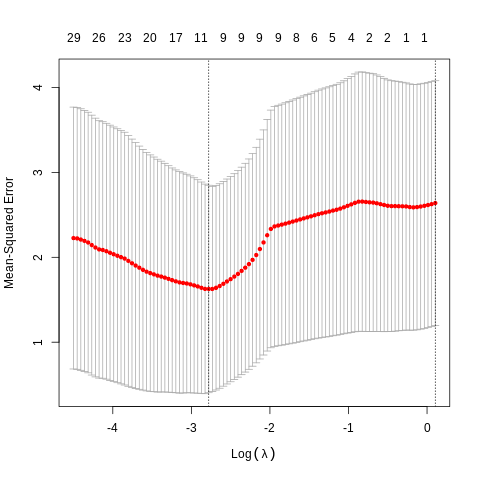

In [37]:
%%R
set.seed(12345)
lassoCV <- cv.glmnet(x = XmatTrain, y = yvecTrain,
                      family = "gaussian",
                      alpha = 1,
                      lambda = NULL,
                      standardize = TRUE,
                      nfolds = 10)
plot(lassoCV)

In [38]:
%%R
lassoCV$lambda.min
coefLamMin <- predict(lassoCV, s = lassoCV$lambda.min, type = "coefficients")
print(coefLamMin)

246 x 1 sparse Matrix of class "dgCMatrix"
                            s1
(Intercept)      -7.997989e+00
GDPC1             .           
PCECC96           .           
PCDGx             .           
PCESVx            .           
PCNDx             .           
GPDIC1            .           
FPIx              .           
Y033RC1Q027SBEAx  .           
PNFIx             .           
PRFIx             .           
A014RE1Q156NBEA   1.951902e-01
GCEC1             .           
A823RL1Q225SBEA   .           
FGRECPTx          .           
SLCEx             .           
EXPGSC1           .           
IMPGSC1           .           
DPIC96            .           
OUTNFB            .           
OUTBS             .           
OUTMS             .           
INDPRO            .           
IPFINAL           .           
IPCONGD           .           
IPMAT             .           
IPDMAT            .           
IPNMAT            .           
IPDCONGD          2.226205e-02
IPB51110SQ        3.897019e

In [39]:
%%R
lassoCV$lambda.1se
coefLam1SE <- predict(lassoCV, s = lassoCV$lambda.1se, type = "coefficients")
print(coefLam1SE)

246 x 1 sparse Matrix of class "dgCMatrix"
                        s1
(Intercept)      0.4852243
GDPC1            .        
PCECC96          .        
PCDGx            .        
PCESVx           .        
PCNDx            .        
GPDIC1           .        
FPIx             .        
Y033RC1Q027SBEAx .        
PNFIx            .        
PRFIx            .        
A014RE1Q156NBEA  .        
GCEC1            .        
A823RL1Q225SBEA  .        
FGRECPTx         .        
SLCEx            .        
EXPGSC1          .        
IMPGSC1          .        
DPIC96           .        
OUTNFB           .        
OUTBS            .        
OUTMS            .        
INDPRO           .        
IPFINAL          .        
IPCONGD          .        
IPMAT            .        
IPDMAT           .        
IPNMAT           .        
IPDCONGD         .        
IPB51110SQ       .        
IPNCONGD         .        
IPBUSEQ          .        
IPB51220SQ       .        
TCU              .        
CUMFNS      

In [40]:
%%R
lassoYhat <- predict(lassoCV, s = lassoCV$lambda.min, newx = XmatValidation)
lassoMSE <- mean((yvecValidation - lassoYhat)^2)
lassoRMSE <- sqrt(lassoMSE)
lassoRMSE

[1] 0.3627916
